In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from os import path
import seaborn as sns
from scipy import sparse, io
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from dotenv import load_dotenv, find_dotenv
%matplotlib notebook

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

RAW_DATA_DIR = os.environ.get("RAW_DATA_DIR")

train = pd.read_csv(path.join(RAW_DATA_DIR, 'gender_age_train.csv'))
events = pd.read_csv(path.join(RAW_DATA_DIR, 'events.csv'))

In [2]:
# EVENTS

events[['longitude', 'latitude']].describe()
lo = events['longitude'].value_counts()
la = events['latitude'].value_counts()
print lo.head()
print la.head()

0.00      968711
1.00       76362
104.00     27977
116.39     14751
116.33      6721
Name: longitude, dtype: int64
0.00     968955
1.00      76375
30.00     28466
39.91     19289
34.74      6964
Name: latitude, dtype: int64


In [3]:
sea_lo = lo.ix[[0,1]].sum()
land_lo = lo.drop([0,1])
land_lo = land_lo.sum()
sea_lo > land_lo/3

True

In [4]:
sea_la = la.ix[[0,1]].sum()
land_la = la.drop([0,1])
land_la = land_la.sum()
sea_la > land_la/3

True

<IPython.core.display.Javascript object>


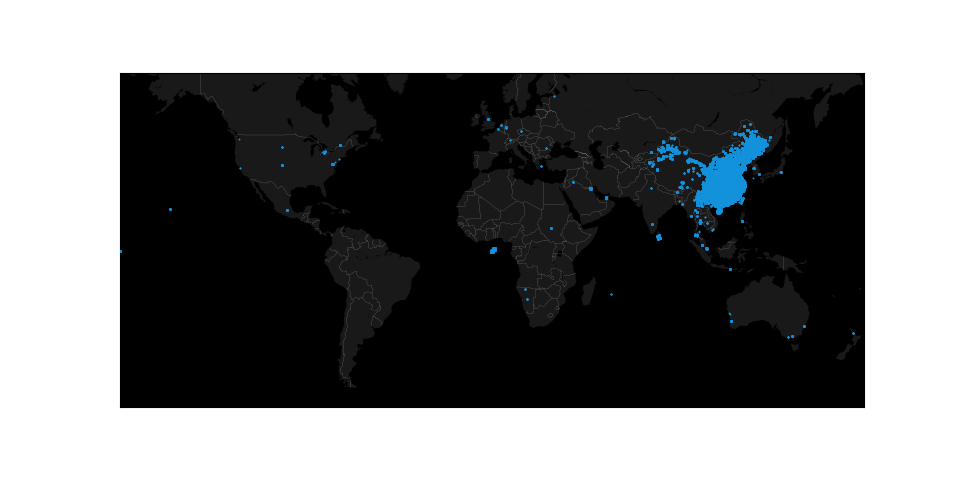

In [5]:
# Mercator of World
plt.figure(1, figsize=(12,6))
m1 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000')                # black background
m1.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m1(events["longitude"].tolist(), events["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

#plt.title("Global view of events")
plt.show()

events_train = train.merge(events, how='left', on='device_id')

female_events = events_train[events_train['gender'] == 'F']
male_events = events_train[events_train['gender'] == 'M']

<IPython.core.display.Javascript object>


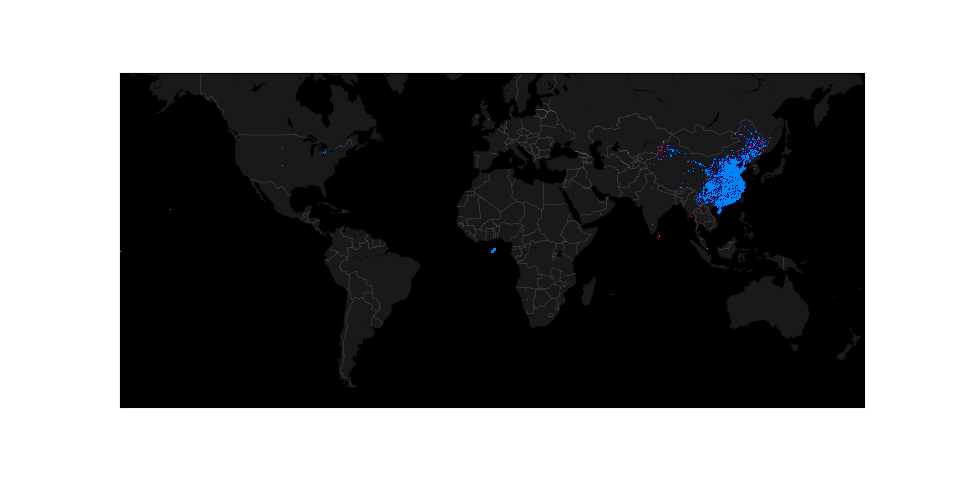

In [6]:
plt.figure(2, figsize=(12,6))
m2 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m2.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000')                # black background
m2.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m2(female_events["longitude"].tolist(), female_events["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=1, c="#f60087", lw=0, alpha=0.5, zorder=5)

mxy = m2(male_events["longitude"].tolist(), male_events["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=1, c="#0087f6", lw=0, alpha=0.5, zorder=5)

<IPython.core.display.Javascript object>


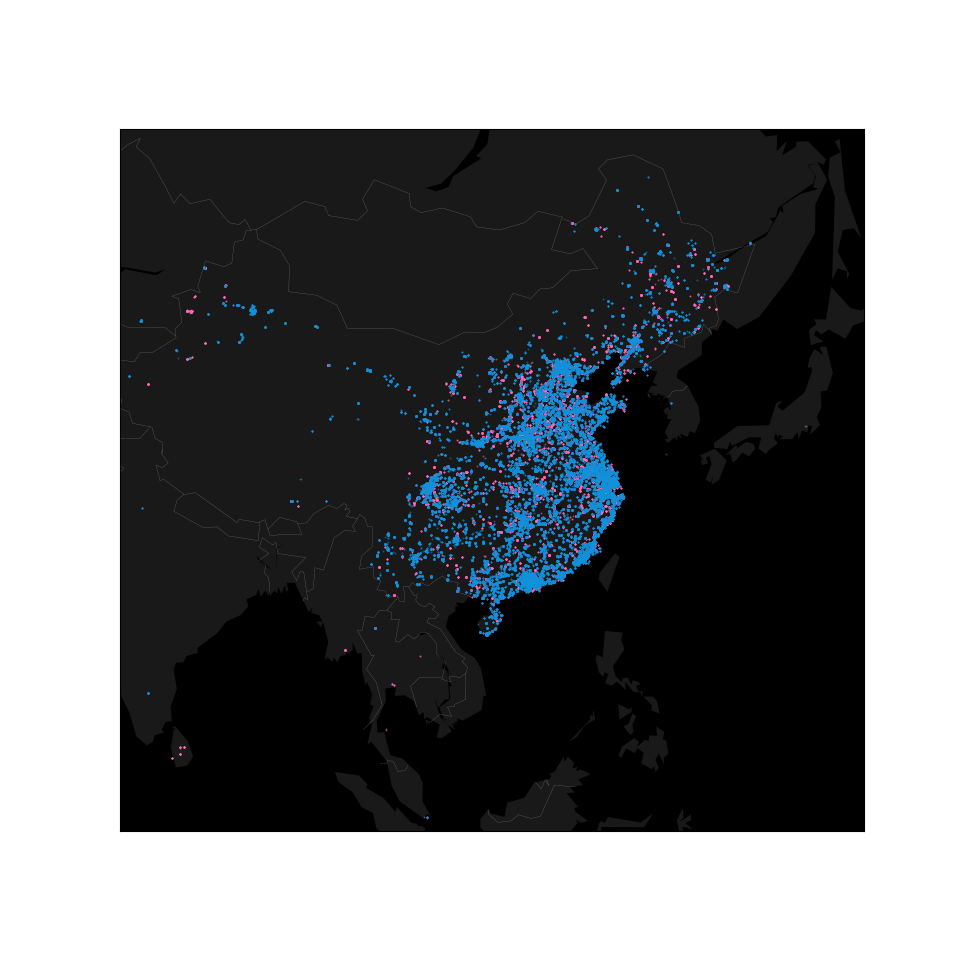

In [6]:
plt.figure(3, figsize=(12,12))
m3 = Basemap(projection='merc',
             llcrnrlat=0,
             urcrnrlat=55,
             llcrnrlon=75,
             urcrnrlon=145,
             lat_ts=0,
             resolution='c')

m3.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m3.drawmapboundary(fill_color='#000000')                # black background
m3.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m3(female_events["longitude"].tolist(), female_events["latitude"].tolist())
m3.scatter(mxy[0], mxy[1], s=3, c="#ff69b4", lw=0, alpha=0.5, zorder=5)

mxy = m3(male_events["longitude"].tolist(), male_events["latitude"].tolist())
m3.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=0.5, zorder=5)


The tables above show that the majority of the events happen around (0,0) which
is located in the middle of the Atlantic Ocean. It is safe to assume that these
logs on position are a product of users not wanting to share their position and
therefore are useless. The majority of the other coordinates are located in China,
only a few pin users in other parts of the world. Although a third of the data
bears no information I still think it is worth to use the information on position
as the two figures show there is a cerain difference of distribution between females and males


In [7]:
# Make a pivot table showing average age per area of a grid, also store the counts

age_train = train.merge(events, how='left', on='device_id')
age_train = age_train.fillna(-1)
age_train['lon_round2'] = age_train['longitude'].round(decimals=2)
age_train['lat_round2'] = age_train['latitude'].round(decimals=2)
age_train['lon_round1'] = age_train['longitude'].round(decimals=1)
age_train['lat_round1'] = age_train['latitude'].round(decimals=1)
age_train['lon_round'] = age_train['longitude'].round()
age_train['lat_round'] = age_train['latitude'].round()
# remove those events taking place in the middle of the ocean

In [8]:
# Sample it down to only the China region
lon_min, lon_max = 75, 135
lat_min, lat_max = 15, 55

idx_china = (age_train["longitude"]>lon_min) &\
            (age_train["longitude"]<lon_max) &\
            (age_train["latitude"]>lat_min) &\
            (age_train["latitude"]<lat_max)

age_train_china = (age_train[idx_china])
age_train_china.shape
df_age_china = pd.pivot_table(age_train_china,
                        values='age',
                        index='lon_round1',
                        columns='lat_round1',
                        aggfunc=np.mean)
df_age_china.shape
df_cnt_china = pd.pivot_table(age_train_china,
                        values='age',
                        index='lon_round1',
                        columns='lat_round1',
                        aggfunc='count')
df_cnt_china.shape


(388, 314)

<IPython.core.display.Javascript object>


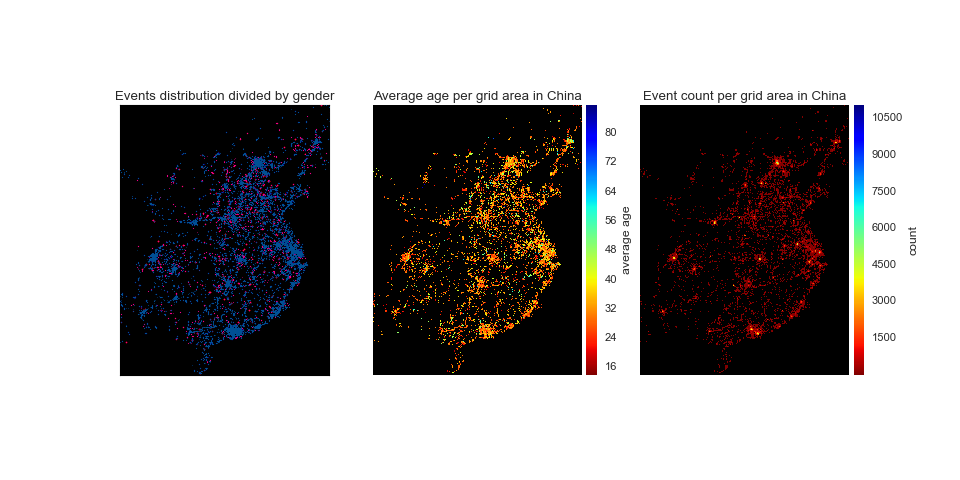

In [9]:
from matplotlib import gridspec

plt.figure(6, figsize=(12,6))
gs = gridspec.GridSpec(1, 3, width_ratios=[0.935, 1, 1])
plt.subplot(gs[0])
m5c = Basemap(projection='merc',
             llcrnrlat=18,
             urcrnrlat=45,
             llcrnrlon=100,
             urcrnrlon=125,
             lat_ts=35,
             resolution='c')
# m5c.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m5c.drawmapboundary(fill_color='#000000')                # black background
# m5c.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m5c(female_events["longitude"].tolist(), female_events["latitude"].tolist())
m5c.scatter(mxy[0], mxy[1], s=1, c="#f60087", lw=0, alpha=0.5, zorder=5)

mxy = m5c(male_events["longitude"].tolist(), male_events["latitude"].tolist())
m5c.scatter(mxy[0], mxy[1], s=1, c="#005296", lw=0, alpha=0.5, zorder=5)

plt.title('Events distribution divided by gender')

plt.subplot(gs[1])
m5a = Basemap(projection='merc',
             llcrnrlat=18,
             urcrnrlat=45,
             llcrnrlon=100,
             urcrnrlon=125,
             lat_ts=35,
             resolution='c')

# Construct a heatmap
lons = df_age_china.index.values
lats = df_age_china.columns.values
x, y = np.meshgrid(lons, lats)
px, py = m5a(x, y)
data_values = df_age_china.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap= plt.cm.jet_r
cmap.set_bad(color="#000000")

# Plot the heatmap
m5a.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5a.colorbar().set_label('average age')
plt.title('Average age per grid area in China')

plt.subplot(gs[2])
m5b = Basemap(projection='merc',
             llcrnrlat=18,
             urcrnrlat=45,
             llcrnrlon=100,
             urcrnrlon=125,
             lat_ts=35,
             resolution='c')
# Construct a heatmap
data_values = df_cnt_china.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.jet_r
cmap.set_bad(color="#000000")
# Plot the heatmap
m5b.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5b.colorbar().set_label("count")
plt.title("Event count per grid area in China")

plt.show()

In [17]:

# Sample it down to only the Beijing region
lon_min, lon_max = 116, 117
lat_min, lat_max = 39.75, 40.25

idx_beijing = (age_train["longitude"]>lon_min) &\
              (age_train["longitude"]<lon_max) &\
              (age_train["latitude"]>lat_min) &\
              (age_train["latitude"]<lat_max)
df_plot = age_train[idx_beijing]

df_age_beij = pd.pivot_table(df_plot,
                        values='age',
                        index='longitude',
                        columns='latitude',
                        aggfunc=np.mean)

df_cnt_beij = pd.pivot_table(df_plot,
                        values='age',
                        index='longitude',
                        columns='latitude',
                        aggfunc='count')

<IPython.core.display.Javascript object>


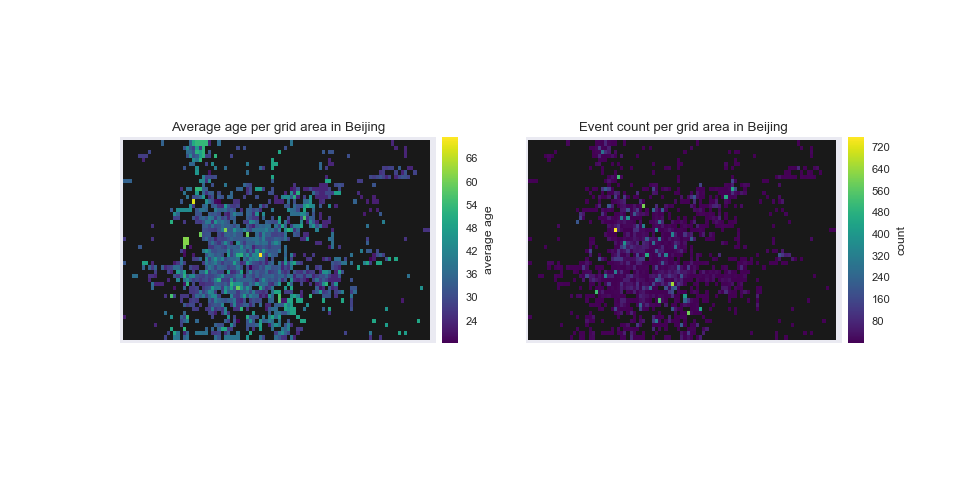

In [18]:

# Age plot
plt.figure(7, figsize=(12,6))
# Plot avg age per grid
plt.subplot(121)
m5a = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')
# Construct a heatmap
lons = df_age_beij.index.values
lats = df_age_beij.columns.values
x, y = np.meshgrid(lons, lats)
px, py = m5a(x, y)
data_values = df_age_beij.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#191919")
# Plot the heatmap
m5a.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5a.colorbar().set_label("average age")
plt.title("Average age per grid area in Beijing")

# Plot count per grid
plt.subplot(122)
m5b = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')
# Construct a heatmap
data_values = df_cnt_beij.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#191919")
# Plot the heatmap
m5b.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5b.colorbar().set_label("count")
plt.title("Event count per grid area in Beijing")

plt.show()

<IPython.core.display.Javascript object>


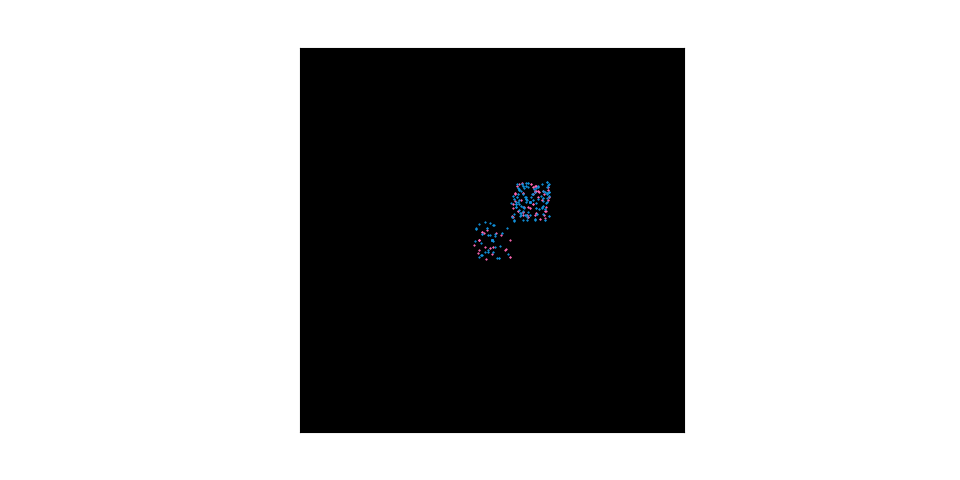

In [13]:
#middle of the oocean
lon_min, lon_max = -5, 5
lat_min, lat_max = -5, 5

plt.figure(8, figsize=(12,6))
m2 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=0,
             resolution='c')

m2.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000')                # black background
m2.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m2(female_events["longitude"].tolist(), female_events["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=3, c="#ff69b4", lw=0, alpha=0.5, zorder=5)

mxy = m2(male_events["longitude"].tolist(), male_events["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=0.5, zorder=5)

plt.show()